In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00


In [53]:
from google.colab import userdata
import getpass
import textwrap
from typing_extensions import TypedDict
from typing import List

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage
from langchain.prompts import PromptTemplate

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages

from IPython.display import Image, display, Markdown

In [44]:
# testing the llm

google_api_key = userdata.get('GOOGLE_API_KEY')
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',
                                                    api_key=google_api_key
                                                    )
prompt: HumanMessage = HumanMessage(content="What is  2+2?")
messages = [prompt]
response: AIMessage = llm.invoke(messages)

print(response.content)

2 + 2 = 4 



In [77]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [78]:
def text_classification(state: State):
  """Classify text into one of the categories: News, Blog, Research or Other"""

  text = state['text']
  prompt = f"You will be given a text {text} and you have to classify in one of the categories: News, Blog, Research, or Other. Just return the category"
  message = [prompt]
  classification = llm.invoke(message).content
  return {"classification": classification}

def entity_extraction(state: State ):
  """Extract all the entities (Person, Organization, Location) from the text"""

  input_text = state['text']
  prompt = f"""You will get an input text {input_text} that you will identify and extract
  key entities such as persons, organizations, and locations from the text. Just give the
  entities only in form of list"""
  message = [prompt]
  entities = llm.invoke(message).content
  return {"entities": entities}

def text_summarization(state: State):
  """Sumarize given text in one short sentence"""

  input_text = state['text']
  prompt = f"""You will get an input text {input_text} that you will summarize in one sentence."""
  summary: AIMessage = llm.invoke(prompt).content
  return {"summary": summary}

In [79]:
builder: StateGraph = StateGraph(State)

builder.add_node("text_classification", text_classification)
builder.add_node("entity_extraction", entity_extraction)
builder.add_node("text_summarization", text_summarization)

builder.add_edge(START, "text_classification")
builder.add_edge("text_classification", "entity_extraction")
builder.add_edge("entity_extraction", "text_summarization")
builder.add_edge("text_summarization", END)

graph: StateGraph = builder.compile()

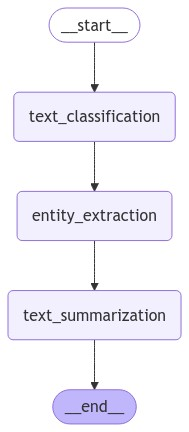

In [80]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
input = {"text": """OpenAI has announced the GPT-4 model, which is a large multimodal
model that exhibits human-level performance on various professional benchmarks.
It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor,
GPT-3. The GPT-4 model is expected to be released in the coming months and will be available
to the public for research and development purposes."""}

result = graph.invoke(input)

In [82]:
print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News 


Entities: - OpenAI
- GPT-4
- GPT-3 


Summary: OpenAI's upcoming GPT-4 model, a multimodal AI with human-level capabilities across various professional benchmarks, aims to improve AI safety and efficiency while being made available for public research and development. 

